<a href="https://colab.research.google.com/github/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/blob/main/IAP_T3_E1_JJTL_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Introducción al Aprendizaje Profundo
# José de Jesús Tapia López
# Tarea 3: Transferencia de conocimiento y redes recurrentes
# 11 de Junio de 2021


## Ejercicio 1

1. Entrena modelos de regresión para predecir edades en el conjunto de datos [UTKFace](https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb). La solución debe cumplir con los siguientes puntos:

* Implementa la tubería de datos usando el conjunto de rostros alineados y recortados.
* Agrega acrecentamiento de datos usando un espejeo horizontal.
Particiona aleatoriamente en subconjuntos entrenamiento 80% y prueba 20%.
* Usando transferencia de conocimiento, entrena un modelo reentrenando solo la  última capa.
* Usando transferencia de conocimiento, entrena un modelo reentrenando toda la red.
* Discute el comportamiento de los modelos durante el entrenamiento y los resultados finales en ambos conjuntos.

## 1. Preparación

In [ ]:
# Colab
! pip install torchinfo

### 1.1 Bibliotecas

In [ ]:
# marcas de tiempo
import datetime
# explorar el sistema de archivos
import glob
# sistema de archivos
import os
# funciones aleatorias
import random
# marcas de tiempo
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
# leer archivo matlab
from scipy.io import loadmat
# cargador de datos
from torch.utils.data import DataLoader
# trazas de Tensorboard
from torch.utils.tensorboard import SummaryWriter
# inspección de arquitectura
from torchinfo import summary
# barra de progreso
from tqdm import tqdm
from tqdm.notebook import trange
# imágenes
from PIL import Image

# R^2
from sklearn.metrics import r2_score

### 1.2. Auxiliares

In [ ]:
# directorio de datos (donde quiero que se descarguen mis datos)
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 224

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)


def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

## 2. Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/comida_datos.svg" width="950" height="750" />

El DataLoader se encarga de empaquetar los ejemplos en un lote.

### 2.2 Conjunto de datos

Vamos a descargar los datos



In [ ]:
tvu.download_and_extract_archive(
          url='https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download',
          download_root=DATA_DIR,
          filename='UTKFace.tar.gz',
          md5='ae1a16905fbd795db921ff1d940df9cc'
      )


Extracting ../datos/UTKFace.tar.gz to ../datos


In [ ]:
images = os.listdir(DATA_DIR+'/UTKFace')


Edad:  21


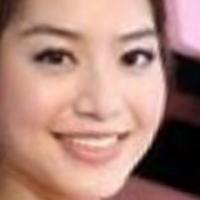

In [ ]:
# mostramos un ejemplo
imag = Image.open(DATA_DIR+'/UTKFace/'+images[0])
print("Edad: ", int(images[0].split("_")[0]))
imag

In [ ]:
# tamanio de la base de datos
len(images)

23708

In [ ]:
class UTKFace:

    def __init__(self, root, subset, split=0.80, seed=0, transform=None):
        # guardamos atributos
        self.root = join(root, 'UTKFace')
        # proporcion de los datos de entrenamiento
        self.split = split
        # subconjunto de datos
        self.subset = subset
        # si aplicamos transformacion
        self.transform = transform
        
        imagenes = sorted(os.listdir(self.root))
        # fijamos el barajeo para reproducibilidad
        random.Random(seed).shuffle(imagenes) 
        # obtenemos la edad de cada participante
        edades = []
        for im in imagenes:
          edades.append(int(im.split("_")[0]))

        # hacemos la particion de datos en entrenamiento y prueba
        tamanio_trn = int(len(imagenes)*self.split) 
        if self.subset == "trn":
            self.imagenes = imagenes[:tamanio_trn]
            self.edades = edades[:tamanio_trn]
        elif self.subset == "tst":
            self.imagenes = imagenes[tamanio_trn:]
            self.edades = edades[tamanio_trn:]
        # subconjuntos solamente de entrenamiento y prueba
        else:
          ValueError(f'invalid value for subset={subset}')


    def __getitem__(self, i):
        # cargamos la imagen
        imagen = self.imagenes[i]
        img = Image.open(join(self.root,imagen))
        #print(self.root,imagen)
        # aplicamos transformación
        if self.transform is not None:
            img = self.transform(img)
        edad = self.edades[i]
 
        return img, edad

    def __len__(self):
        # regresamos numeros de ejemplos
        return len(self.imagenes)

In [ ]:
ds_trn = UTKFace(DATA_DIR,'trn')

In [ ]:
len(ds_trn)

18966

Imagen dimensiones=(200, 200) tipo=<class 'PIL.JpegImagePlugin.JpegImageFile'>
Edad int=54


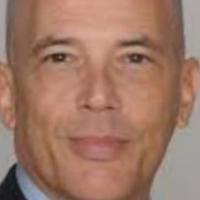

In [ ]:
x, edad = ds_trn[4]
print(f'Imagen dimensiones={x.size} tipo={type(x)}')
print(f'Edad int={edad}')
x

### 2.3 Transformaciones

Torchvision tiene un conjunto de [transformaciones](https://pytorch.org/docs/1.6.0/torchvision/transforms.html) para ser ejecutadas de forma secuencial cuando se la pasamos a la clase `Compose`.

Vemos que en un principio no establecimos las transfromaciones, por lo que ahora sí vamos a incluir el espejeo horizontal.

In [ ]:
# transformación de entrenamiento
trn_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # aumentado de datos
    # espejeo horizontal aleatorio
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto de entrenamiento
trn_ds =  UTKFace(DATA_DIR,'trn', transform=trn_tsfm)

In [ ]:
# transformación de prueba
tst_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# conjunto de prueba
tst_ds = UTKFace(DATA_DIR,'tst', transform=tst_tsfm)

In [ ]:
len(tst_ds)

4742

### 2.4 Cargadores de datos

Los [cargadores de datos](https://pytorch.org/docs/1.6.0/data.html) pueden precargar el siguiente lote de de entrenamiento forma paralela si especificamos `num_workers => 2`.

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/data-loading1.png" />
<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/data-loading2.png" />
Fuente: tensorflow.org

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
edad shape=torch.Size([32]) dtype=torch.int64


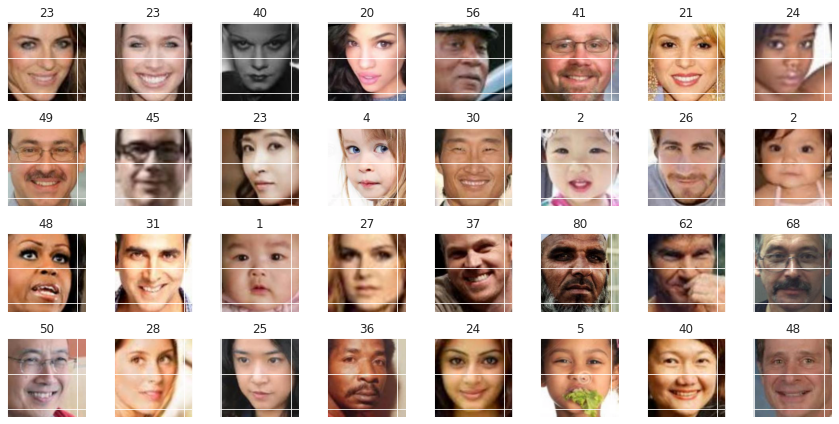

In [ ]:
# creamos cargador
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=2
)
# desplegamos lote
x, edad  = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'edad shape={edad.shape} dtype={edad.dtype}')
display_batch(x, edad.numpy(), ROWS, COLS)

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
edad shape=torch.Size([32]) dtype=torch.int64


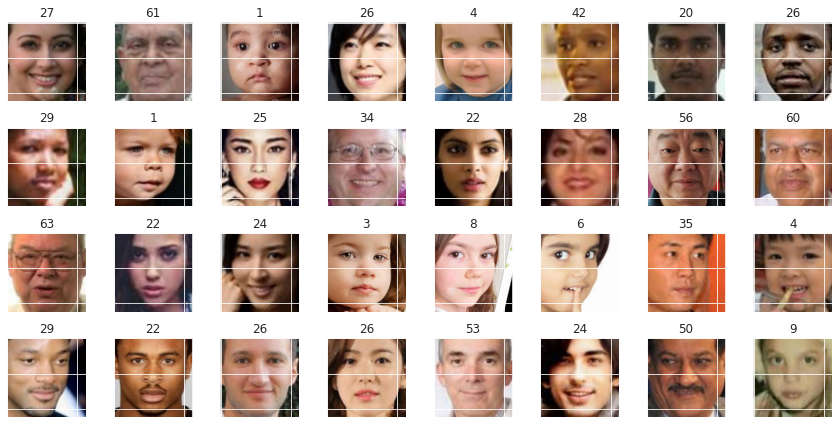

In [ ]:
# creamos cargador
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=2
)
# desplegamos lote
x, edad = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'edad shape={edad.shape} dtype={edad.dtype}')
display_batch(x, edad.numpy(), ROWS, COLS)

## 3. Modelo: Shufflenet V2

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164) y Mobilenet V2. 

In [ ]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

Podemos observar que el número de características en la última capa es: 1024. Además, necesitamos que sea un regresor, no un clasificador, por ello, hacemos las respectivas modificaciones.



In [ ]:
class Reg(nn.Module):
    
    def __init__(self, pretrained):
        super(Reg, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.shufflenet_v2_x0_5(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.fc = nn.Identity()

        in_features = 1024
        # armamos la capa de regresión
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(x)
        # [N, 1024] => [N, 1]
        x = self.reg(x)
        return x
    
model = Reg(True)


# congelamos (parametros de la red) y no van a requerir gradiente
for param in model.cnn.parameters():
  # no participa en la retropropagación
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model.eval()

### Inspección de la arquitectura

In [ ]:
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), device='cuda', verbose=0)
#summary(model, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                        Output Shape              Param #
Reg                                           --                        --
├─ShuffleNetV2: 1-1                           [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 24, 112, 112]         (648)
│    │    └─BatchNorm2d: 3-2                  [1, 24, 112, 112]         (48)
│    │    └─ReLU: 3-3                         [1, 24, 112, 112]         --
│    └─MaxPool2d: 2-2                         [1, 24, 56, 56]           --
│    └─Sequential: 2-3                        [1, 48, 28, 28]           --
│    │    └─InvertedResidual: 3-4             [1, 48, 28, 28]           (2,400)
│    │    └─InvertedResidual: 3-5             [1, 48, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-6             [1, 48, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-7             [1, 48, 28, 28]           (1,

In [ ]:
# congelado de estadísticas de todo el modelo
_ = model.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


## 4. Entrenamiento
<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/comida_entrenamiento.svg" width="650" />

## Entrenamos el modelo reentrenando solo la última capa.

La siguiente función entrena un modelo dado reentrenando solo la última capa

In [ ]:
def trainUltimaEpoca(model, device, EPOCHS=20):
  # optimizador
  opt = optim.Adam(model.parameters(), lr=1e-3)

  # ciclo de entrenamiento

  # historiales
  mse_trn_hist, r2_trn_hist = [], []
  mse_tst_hist, r2_tst_hist = [], []
  for epoch in range(EPOCHS):
      
      # capas de regresión en modo de entrenamiento
      model.reg.train()
      # historiales
      mses_trn, r2s_trn = [], []
      # entrenamiento de una época
      for x, y_true in tqdm(trn_dl, desc=f'E{epoch:2d} Train'):
          # movemos a dispositivo
          x = x.to(device)
          y_true = y_true.to(device)
          # computamos la prediccion
          y_pred = model(x)
          # computamos la pérdida
          mse_trn = F.mse_loss(y_pred, y_true.view(-1,1).float())
          # computamos la r^2
          r2_trn = r2_score(y_true.detach().cpu().numpy(),y_pred.detach().cpu().numpy())
          # guardamos históricos
          mses_trn.append(mse_trn.item())
          r2s_trn.append(r2_trn.item()) 
          # vaciamos los gradientes
          opt.zero_grad()
          # retropropagamos
          mse_trn.backward()
          # actualizamos parámetros
          opt.step()
                 
      # guardamos en historial el promedio de las métricas
      mse_trn_hist.append(np.mean(mses_trn))
      r2_trn_hist.append(np.mean(r2s_trn))

      # capas de regresión en modo de evaluación
      # no movemos las estadisticas de la capa de normalizacion
      model.reg.eval()    
      
      # evitamos que se registren las operaciones 
      # en la gráfica de cómputo
      with torch.no_grad():

          # historiales
          mses_tst, r2s_tst = [], []
          # validación de la época
          for x, y_true in tqdm(tst_dl, desc=f'E{epoch:2d} Test '):
              # movemos a dispositivo
              x = x.to(device)
              y_true = y_true.to(device)
              # computamos la predicción
              y_pred = model(x)
              # computamos la pérdida
              mse_tst = F.mse_loss(y_pred, y_true.view(-1,1).float())
              # computamos la r^2
              r2_tst = r2_score(y_true.detach().cpu().numpy(),y_pred.detach().cpu().numpy())
              # guardamos históricos
              mses_tst.append(mse_tst.item())
              r2s_tst.append(r2_tst.item())

          # guardamos en historial el promedio de las métricas
          mse_tst_hist.append(np.mean(mses_tst))
          r2_tst_hist.append(np.mean(r2s_tst))
      # imprimimos métricas
      print(f'E{epoch:2} mse=[{mse_trn_hist[epoch]:7.2f},{mse_tst_hist[epoch]:7.2f}] R^2=[{r2_trn_hist[epoch]:4.2f},{r2_tst_hist[epoch]:7.2f}]')
  mse_hist = [mse_trn_hist,mse_tst_hist]
  r2_hist = [r2_trn_hist,r2_tst_hist]
  return  mse_hist, r2_hist

In [ ]:
mse_hist, r2_hist = trainUltimaEpoca(model, device)

E 1 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 0 mse=[ 410.29, 160.09] R^2=[-0.11,   0.55]


E 2 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 1 mse=[ 148.48, 141.17] R^2=[0.60,   0.60]


E 3 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 2 mse=[ 138.93, 135.25] R^2=[0.62,   0.62]


E 4 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 3 mse=[ 133.16, 131.54] R^2=[0.64,   0.64]


E 5 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 4 mse=[ 127.88, 127.96] R^2=[0.65,   0.64]


E 6 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 5 mse=[ 126.21, 125.02] R^2=[0.66,   0.65]


E 7 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 6 mse=[ 123.54, 124.23] R^2=[0.66,   0.65]


E 8 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 7 mse=[ 122.70, 123.42] R^2=[0.67,   0.66]


E 9 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 8 mse=[ 122.23, 123.30] R^2=[0.67,   0.48]


E10 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 9 mse=[ 122.26, 123.30] R^2=[0.67,   0.65]


E11 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E10 mse=[ 120.60, 121.54] R^2=[0.67,   0.66]


E12 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E11 mse=[ 119.19, 122.84] R^2=[0.68,   0.66]


E13 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E12 mse=[ 119.93, 121.41] R^2=[0.67,   0.66]


E14 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E13 mse=[ 118.17, 120.88] R^2=[0.67,   0.66]


E15 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E14 mse=[ 119.16, 121.32] R^2=[0.67,   0.67]


E16 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E15 mse=[ 119.59, 121.74] R^2=[0.67,   0.66]


E17 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E16 mse=[ 119.22, 121.20] R^2=[0.67,   0.66]


E18 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E17 mse=[ 117.05, 120.55] R^2=[0.68,   0.66]


E19 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E18 mse=[ 117.84, 121.12] R^2=[0.68,   0.66]


E19 Test : 100%|██████████| 149/149 [00:11<00:00, 12.72it/s]

E19 mse=[ 118.26, 120.88] R^2=[0.67,   0.67]


### Gráficas de pérdidas y $R^2$

In [ ]:
EPOCHS = 20

In [ ]:
# Funcion para graficar perdida (mse) de cada epoca
def msePlot(mse_hist, titulo='Reentrenando solo la última época'):
  trn_mse, tst_mse = mse_hist[0], mse_hist[1]
  plt.plot(trn_mse, '-o',color='tab:orange', label='MSE entrenamiento')
  plt.plot(tst_mse, '-o',color='tab:red', label='MSE prueba')
  plt.legend(loc='upper right')
  plt.xlabel('Época', fontsize=12)
  plt.ylabel('MSE',fontsize=12)
  plt.xticks(np.arange(0,EPOCHS), np.arange(0,EPOCHS), fontsize=12)
  plt.yticks(fontsize=12)
  #plt.ylim(30,100)
  plt.title(titulo, fontsize=14)
  plt.show()

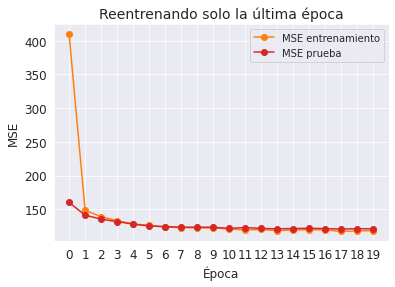

In [ ]:
 msePlot(mse_hist)

In [ ]:
# funcion para graficar r2 de cada epoca
def r2Plot(r2_hist, titulo='Reentrenando solo la última época'):
  trn_r2, tst_r2 = r2_hist[0], r2_hist[1]
  plt.plot(trn_r2, '-o',color='tab:blue', label=r'$R^2$ entrenamiento')
  plt.plot(tst_r2, '-o',color='tab:green', label=r'$R^2$ prueba')
  plt.legend(loc='lower right')
  plt.xlabel('Época', fontsize=12)
  plt.ylabel(r'$R^2$',fontsize=12)
  plt.xticks(np.arange(0,EPOCHS), np.arange(0,EPOCHS), fontsize=12)
  plt.yticks(fontsize=12)
  #plt.ylim(0.50,1.00)
  plt.title(titulo, fontsize=14)
  plt.show()

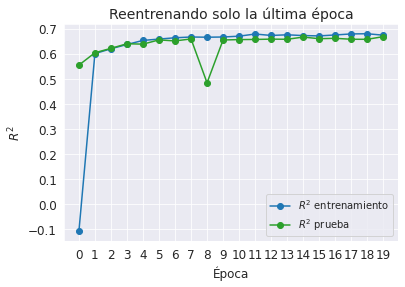

In [ ]:
r2Plot(r2_hist)

### Predicción

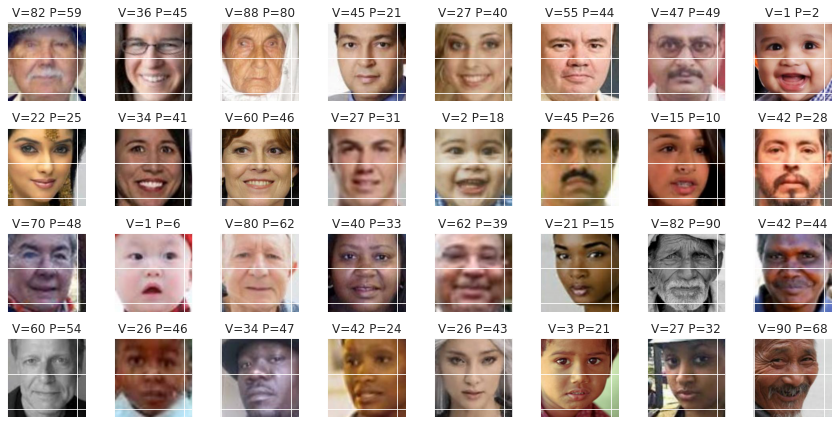

In [ ]:
model.to("cpu")
with torch.no_grad():
    batch = next(iter(tst_dl))
    x, edad = batch
    y_pred = model(x).numpy().astype(int)
    titles = [f'V={t} P={p.item()}' for t, p in zip(edad, y_pred)]
    display_batch(x, titles, ROWS, COLS)

Vemos que algunas predicciones sí son relativamente buenas y otras no. Por ejemplo, a un niñ**e** de 2 años le predice una edad de 18 años, y al señor adulto de 82 años (esquina superior izquierda) le predice una edad de 59 años y tampoco es que se vea de 59 jaja. Entonces, en algunos casos creo que logra hacerlo no tan mal pero puede mejorar.  

Además, como que a partir de la época 9, el modelo ya no mejora. La ventaja de esta parte de reentrenar solo la última capa es que no se sobreajusta. 

## Reentrenando todo el modelo

In [ ]:
model2 = Reg(True)

# congelamos (parametros de la red) y no van a requerir gradiente
for param in model2.cnn.parameters():
  # no participa en la retropropagación
    param.requires_grad = True
# congelado de estadísticas de todo el modelo
_ = model2.eval()

In [ ]:
summary(model2, (1, 3, IMG_SIZE, IMG_SIZE), device='cuda', verbose=0)
#summary(model2, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                        Output Shape              Param #
Reg                                           --                        --
├─ShuffleNetV2: 1-1                           [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2                  [1, 24, 112, 112]         48
│    │    └─ReLU: 3-3                         [1, 24, 112, 112]         --
│    └─MaxPool2d: 2-2                         [1, 24, 56, 56]           --
│    └─Sequential: 2-3                        [1, 48, 28, 28]           --
│    │    └─InvertedResidual: 3-4             [1, 48, 28, 28]           2,400
│    │    └─InvertedResidual: 3-5             [1, 48, 28, 28]           1,512
│    │    └─InvertedResidual: 3-6             [1, 48, 28, 28]           1,512
│    │    └─InvertedResidual: 3-7             [1, 48, 28, 28]           1,512
│    └─

In [ ]:
# congelado de estadísticas de todo el modelo
_ = model2.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
print(device)


cuda


La siguiente función reentrena todo el modelo

In [ ]:
def trainTodo(model, device, EPOCHS=20):
  # optimizador
  opt = optim.Adam(model.parameters(), lr=1e-3)

  # ciclo de entrenamiento

  # historiales
  mse_trn_hist, r2_trn_hist = [], []
  mse_tst_hist, r2_tst_hist = [], []
  for epoch in range(EPOCHS):
      
      model.train()
      # historiales
      mses_trn, r2s_trn = [], []
      # entrenamiento de una época
      for x, y_true in tqdm(trn_dl, desc=f'E{epoch:2d} Train'):
          # movemos a dispositivo
          x = x.to(device)
          y_true = y_true.to(device)
          # computamos la prediccion
          y_pred = model(x)
          # computamos la pérdida
          mse_trn = F.mse_loss(y_pred, y_true.view(-1,1).float())
          # computamos la r^2
          r2_trn = r2_score(y_true.detach().cpu().numpy(),y_pred.detach().cpu().numpy())
          # vaciamos los gradientes
          opt.zero_grad()
          # retropropagamos
          mse_trn.backward()
          # actualizamos parámetros
          opt.step()
          # guardamos históricos
          mses_trn.append(mse_trn.item())
          r2s_trn.append(r2_trn.item())        
    
      # guardamos en historial el promedio de las métricas
      mse_trn_hist.append(np.mean(mses_trn))
      r2_trn_hist.append(np.mean(r2s_trn))

      model.eval()    
      
      # evitamos que se registren las operaciones 
      # en la gráfica de cómputo
      with torch.no_grad():

          # historiales
          mses_tst, r2s_tst = [], []
          # validación de la época
          for x, y_true in tqdm(tst_dl, desc=f'E{epoch:2d} Test '):
              # movemos a dispositivo
              x = x.to(device)
              y_true = y_true.to(device)
              # computamos la predicción
              y_pred = model(x)
              # computamos la pérdida
              mse_tst = F.mse_loss(y_pred, y_true.view(-1,1).float())
              # computamos la r^2
              r2_tst = r2_score(y_true.detach().cpu().numpy(),y_pred.detach().cpu().numpy())
              # guardamos históricos
              mses_tst.append(mse_tst.item())
              r2s_tst.append(r2_tst.item())

          # guardamos en historial el promedio de las métricas
          mse_tst_hist.append(np.mean(mses_tst))
          r2_tst_hist.append(np.mean(r2s_tst))
      # imprimimos métricas
      print(f'E{epoch:2} mse=[{mse_trn_hist[epoch]:7.2f},{mse_tst_hist[epoch]:7.2f}] R^2=[{r2_trn_hist[epoch]:4.2f},{r2_tst_hist[epoch]:7.2f}]')
  mse_hist = [mse_trn_hist,mse_tst_hist]
  r2_hist = [r2_trn_hist,r2_tst_hist]
  return  mse_hist, r2_hist
  

In [ ]:
mse_hist2, r2_hist2 = trainTodo(model2, device)

E 1 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 0 mse=[ 328.49,  80.28] R^2=[0.11,   0.78]


E 2 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 1 mse=[  78.72,  79.31] R^2=[0.78,   0.78]


E 3 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 2 mse=[  68.58,  68.82] R^2=[0.81,   0.81]


E 4 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 3 mse=[  62.70,  76.20] R^2=[0.82,   0.79]


E 5 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 4 mse=[  60.57,  67.77] R^2=[0.83,   0.81]


E 6 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 5 mse=[  56.94,  63.05] R^2=[0.84,   0.83]


E 7 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 6 mse=[  52.69,  60.81] R^2=[0.85,   0.83]


E 8 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 7 mse=[  51.85,  58.62] R^2=[0.85,   0.83]


E 9 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 8 mse=[  48.69,  66.04] R^2=[0.86,   0.81]


E10 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 9 mse=[  46.00,  64.52] R^2=[0.87,   0.82]


E11 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E10 mse=[  45.31,  59.92] R^2=[0.87,   0.83]


E12 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E11 mse=[  44.76,  68.20] R^2=[0.87,   0.81]


E13 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E12 mse=[  41.57,  59.93] R^2=[0.88,   0.83]


E14 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E13 mse=[  41.18,  58.51] R^2=[0.88,   0.84]


E15 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E14 mse=[  38.05,  59.46] R^2=[0.89,   0.84]


E16 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E15 mse=[  37.07,  58.17] R^2=[0.90,   0.84]


E17 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E16 mse=[  36.46,  60.73] R^2=[0.90,   0.83]


E18 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E17 mse=[  35.90,  57.99] R^2=[0.90,   0.84]


E19 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E18 mse=[  33.80,  58.50] R^2=[0.91,   0.83]


E19 Test : 100%|██████████| 149/149 [00:12<00:00, 12.30it/s]

E19 mse=[  33.30,  60.98] R^2=[0.91,   0.83]


### Gráficas de pérdidas y $R^2$

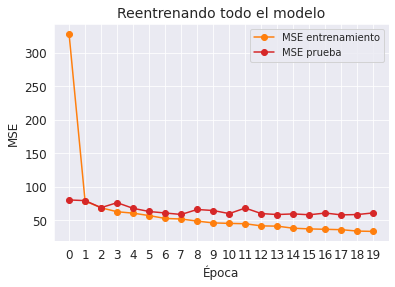

In [ ]:
msePlot(mse_hist2, 'Reentrenando todo el modelo')

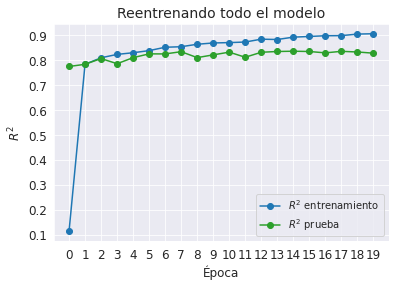

In [ ]:
r2Plot(r2_hist2,'Reentrenando todo el modelo')

### Predicción

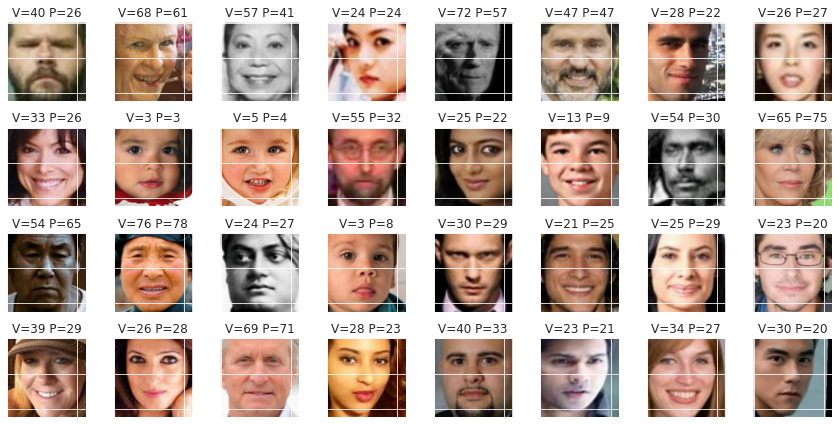

In [ ]:
model2.to("cpu")
with torch.no_grad():
    batch = next(iter(tst_dl))
    x, edad = batch
    y_pred = model2(x).numpy().astype(int)
    titles = [f'V={t} P={p.item()}' for t, p in zip(edad, y_pred)]
    display_batch(x, titles, ROWS, COLS)

Considero que en este caso de la Shufflenet V2 sí mejoran las predicciones. Lo podemos verificar pues tenemos menor MSE y mayor $R^2$ que al reentrenar solo la última capa; aunque aquí al reentrenar todo el modelo hay un mayor sobreajuste, y este es más notable conforme pasaban las épocas, principalmente como que a partir de la época 8.

## Modelo: Mobilenet V2

In [ ]:
# instancia de modelo y carga de pesos
model3 = tvm.mobilenet_v2(pretrained=True)
model3

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

Para este modelo, podemos observar que el número de características en la última capa es: 1280. Además, necesitamos que sea un regresor, no un clasificador, por ello, hacemos las respectivas modificaciones.

In [ ]:
class Reg2(nn.Module):
    
    def __init__(self, pretrained):
        super(Reg2, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.mobilenet_v2(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.classifier = nn.Identity()

        in_features = 1280
        # armamos la capa de regresión
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1280]
        x = self.cnn(x)
        # [N, 1280] => [N, 1]
        x = self.reg(x)
        return x
    
model3 = Reg2(True)


# congelamos (parametros de la red) y no van a requerir gradiente
for param in model3.cnn.parameters():
  # no participa en la retropropagación
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model3.eval()

### Inspección de la arquitectura

In [ ]:
summary(model3, (1, 3, 224, 224), device='cuda', verbose=0)
#summary(model3, (1, 3, 224, 224), device='cpu', verbose=0)

Layer (type:depth-idx)                             Output Shape              Param #
Reg2                                               --                        --
├─MobileNetV2: 1-1                                 [1, 1280]                 --
│    └─Sequential: 2-1                             [1, 1280, 7, 7]           --
│    │    └─ConvBNActivation: 3-1                  [1, 32, 112, 112]         (928)
│    │    └─InvertedResidual: 3-2                  [1, 16, 112, 112]         (896)
│    │    └─InvertedResidual: 3-3                  [1, 24, 56, 56]           (5,136)
│    │    └─InvertedResidual: 3-4                  [1, 24, 56, 56]           (8,832)
│    │    └─InvertedResidual: 3-5                  [1, 32, 28, 28]           (10,000)
│    │    └─InvertedResidual: 3-6                  [1, 32, 28, 28]           (14,848)
│    │    └─InvertedResidual: 3-7                  [1, 32, 28, 28]           (14,848)
│    │    └─InvertedResidual: 3-8                  [1, 64, 14, 14]           (21,

In [ ]:
# congelado de estadísticas de todo el modelo
_ = model3.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = model3.to(device)
print(device)

cuda


## Entrenamos el modelo reentrenando solo la última capa.

In [ ]:
mse_hist3, r2_hist3 = trainUltimaEpoca(model3, device)

E 1 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 0 mse=[ 392.16, 157.64] R^2=[-0.06,   0.57]


E 2 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 1 mse=[ 153.70, 148.25] R^2=[0.58,   0.59]


E 3 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 2 mse=[ 147.47, 143.92] R^2=[0.60,   0.60]


E 4 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 3 mse=[ 142.83, 142.31] R^2=[0.61,   0.61]


E 5 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 4 mse=[ 141.73, 140.71] R^2=[0.61,   0.61]


E 6 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 5 mse=[ 138.48, 137.30] R^2=[0.62,   0.62]


E 7 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 6 mse=[ 136.00, 135.64] R^2=[0.63,   0.62]


E 8 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 7 mse=[ 134.71, 135.29] R^2=[0.63,   0.63]


E 9 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 8 mse=[ 132.68, 134.78] R^2=[0.64,   0.63]


E10 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 9 mse=[ 133.58, 133.43] R^2=[0.64,   0.63]


E11 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E10 mse=[ 132.43, 134.06] R^2=[0.64,   0.55]


E12 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E11 mse=[ 131.90, 133.38] R^2=[0.64,   0.63]


E13 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E12 mse=[ 130.38, 132.74] R^2=[0.64,   0.63]


E14 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E13 mse=[ 129.48, 131.58] R^2=[0.65,   0.63]


E15 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E14 mse=[ 129.93, 130.83] R^2=[0.65,   0.63]


E16 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E15 mse=[ 129.57, 130.66] R^2=[0.65,   0.63]


E17 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E16 mse=[ 130.16, 131.17] R^2=[0.65,   0.63]


E18 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E17 mse=[ 129.25, 129.89] R^2=[0.65,   0.64]


E19 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E18 mse=[ 128.78, 129.67] R^2=[0.65,   0.64]


E19 Test : 100%|██████████| 149/149 [00:12<00:00, 11.89it/s]

E19 mse=[ 127.52, 130.57] R^2=[0.65,   0.64]


### Gráficas de pérdidas y $R^2$

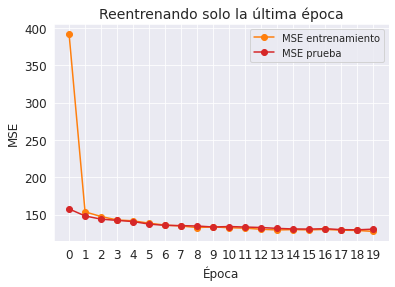

In [ ]:
 msePlot(mse_hist3)

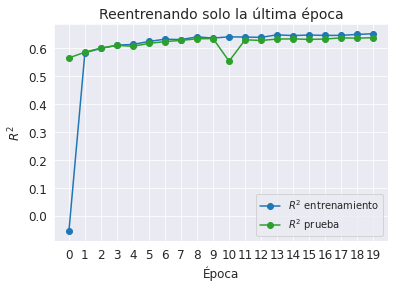

In [ ]:
r2Plot(r2_hist3)

### Predicción

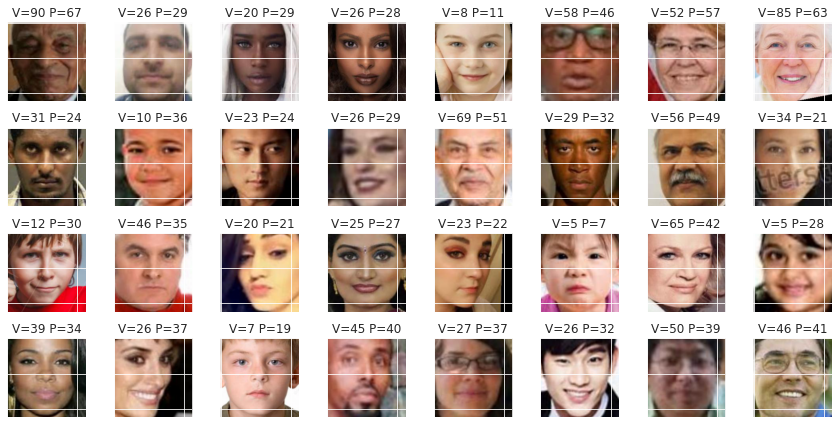

In [ ]:
model3.to("cpu")
with torch.no_grad():
    batch = next(iter(tst_dl))
    x, edad = batch
    y_pred = model3(x).numpy().astype(int)
    titles = [f'V={t} P={p.item()}' for t, p in zip(edad, y_pred)]
    display_batch(x, titles, ROWS, COLS)

Aquí tenemos resultados similares que con la Shufflenet V2. Podemos apreciar que algunas predicciones sí son relativamente buenas y otras no. Por ejemplo, a un niño de 10 años le predice una edad de 36 años, y al señor adulto de 90 años (esquina superior izquierda) le predice una edad de 67 años. Entonces, en algunos casos logra hacerlo creo que no tan mal pero también puede mejorar.

Además, como que a partir de la época 2, el modelo va mejorando muy poquito conforme pasan las épocas. Aquí también al reentrenar solo la última capa vemos que no se sobreajusta, aunque es un poco mejor la Shufflenet V2.


## Reentrenando todo el modelo

In [ ]:
model4 = Reg2(True)

# congelamos (parametros de la red) y no van a requerir gradiente
for param in model4.cnn.parameters():
  # no participa en la retropropagación
    param.requires_grad = True
# congelado de estadísticas de todo el modelo
_ = model4.eval()

In [ ]:
summary(model4, (1, 3, IMG_SIZE, IMG_SIZE), device='cuda', verbose=0)
#summary(model4, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                             Output Shape              Param #
Reg2                                               --                        --
├─MobileNetV2: 1-1                                 [1, 1280]                 --
│    └─Sequential: 2-1                             [1, 1280, 7, 7]           --
│    │    └─ConvBNActivation: 3-1                  [1, 32, 112, 112]         928
│    │    └─InvertedResidual: 3-2                  [1, 16, 112, 112]         896
│    │    └─InvertedResidual: 3-3                  [1, 24, 56, 56]           5,136
│    │    └─InvertedResidual: 3-4                  [1, 24, 56, 56]           8,832
│    │    └─InvertedResidual: 3-5                  [1, 32, 28, 28]           10,000
│    │    └─InvertedResidual: 3-6                  [1, 32, 28, 28]           14,848
│    │    └─InvertedResidual: 3-7                  [1, 32, 28, 28]           14,848
│    │    └─InvertedResidual: 3-8                  [1, 64, 14, 14]           21,056
│    │    └

In [ ]:
# congelado de estadísticas de todo el modelo
_ = model4.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = model4.to(device)
print(device)


cuda


In [ ]:
mse_hist4, r2_hist4 = trainTodo(model4, device)

E 1 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 0 mse=[ 344.49,  85.62] R^2=[0.07,   0.75]


E 2 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 1 mse=[  88.82, 115.06] R^2=[0.75,   0.68]


E 3 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 2 mse=[  80.19,  68.58] R^2=[0.77,   0.81]


E 4 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 3 mse=[  76.79,  86.04] R^2=[0.79,   0.76]


E 5 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 4 mse=[  72.76,  88.04] R^2=[0.79,   0.74]


E 6 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 5 mse=[  66.43,  66.43] R^2=[0.81,   0.81]


E 7 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 6 mse=[  66.58,  69.11] R^2=[0.81,   0.80]


E 8 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 7 mse=[  63.91,  77.59] R^2=[0.82,   0.78]


E 9 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 8 mse=[  60.12,  62.52] R^2=[0.83,   0.82]


E10 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 9 mse=[  55.92,  60.12] R^2=[0.85,   0.83]


E11 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E10 mse=[  54.63,  77.64] R^2=[0.85,   0.79]


E12 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E11 mse=[  54.26,  67.13] R^2=[0.85,   0.82]


E13 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E12 mse=[  49.80,  56.35] R^2=[0.86,   0.84]


E14 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E13 mse=[  48.60,  68.48] R^2=[0.86,   0.80]


E15 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E14 mse=[  47.04,  57.21] R^2=[0.87,   0.84]


E16 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E15 mse=[  48.25,  58.76] R^2=[0.86,   0.83]


E17 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E16 mse=[  45.23,  55.65] R^2=[0.87,   0.85]


E18 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E17 mse=[  45.07,  59.10] R^2=[0.87,   0.84]


E19 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E18 mse=[  43.14,  57.64] R^2=[0.88,   0.84]


E19 Test : 100%|██████████| 149/149 [00:12<00:00, 12.38it/s]

E19 mse=[  42.88,  60.90] R^2=[0.88,   0.83]


### Gráficas de pérdidas y $R^2$

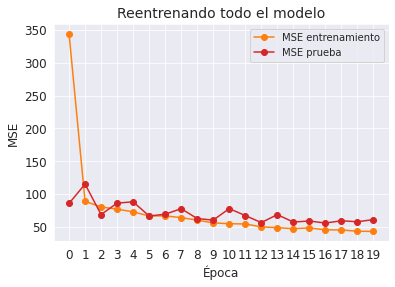

In [ ]:
msePlot(mse_hist4, 'Reentrenando todo el modelo')

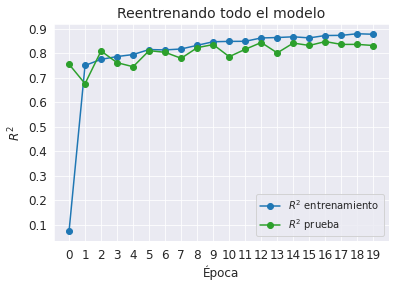

In [ ]:
r2Plot(r2_hist4, 'Reentrenando todo el modelo')

### Predicción

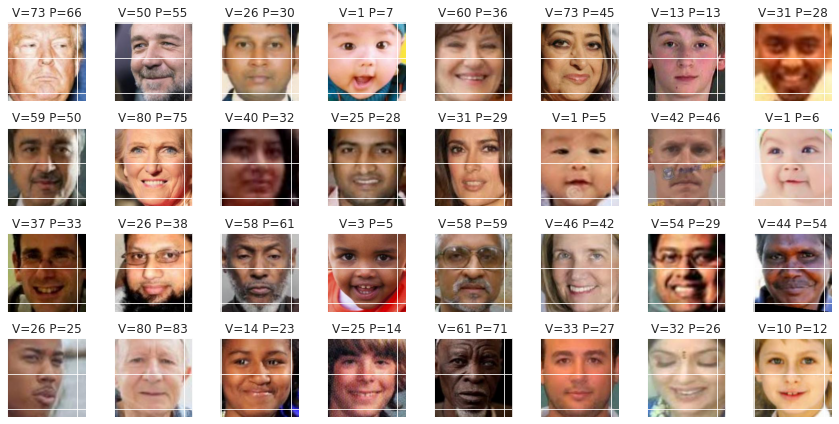

In [ ]:
model4.to("cpu")
with torch.no_grad():
    batch = next(iter(tst_dl))
    x, edad = batch
    y_pred = model4(x).numpy().astype(int)
    titles = [f'V={t} P={p.item()}' for t, p in zip(edad, y_pred)]
    display_batch(x, titles, ROWS, COLS)

Análogamente como ocurre con la Shufflenet V2, al reentrenar todo el modelo de la Mobilenet V2 vemos que también mejoran las predicciones. Lo podemos verificar pues tenemos menor MSE y mayor R2 que al reentrenar solo la última capa; aunque al reentrenar todo el modelo hay un poco más de sobreajuste (al comparar con reentrenando solo la última capa) pero es menor este que en el caso de la Sufflenet V2. 

# Conclusiones

Podemos observar que tanto con Shufflenet V2 y Mobilenet V2 tenemos un mejor rendimiento reentrenando todo el modelo. Sin embargo, en este caso en las gráficas de pérdida y $R^2$ de Shufflenet V2 podemos observar un mayor sobreajuste que con Mobilenet V2, y Shufflenet V2 tiene una menor cantidad de parámetros que la otra arquitectura. Hay ocasiones en que al incrementar el número de parámetros  en cualquier modelo la $R^2$ sube pero no siempre es un indicador que sea un mejor modelo que al quitarle algunos de sus parámetros. Afortunadamente, consideramos que las predicciones sí son relativamente buenas con estas arquitecturas con muchos parámetros; aunque esperaríamos más de la Mobilenet V2 porque tiene más de 2 millones de parámetros.

Por otro lado, cuando entrenamos los dos modelos reentrenando solo la última capa consideramos que no tienen un tan mal rendimiento considerando que su cantidad de parámetros es muy baja en comparación que cuando reentramos todo el modelo (tanto en Shufflenet V2 como en Mobilenet V2);  aunque en este caso es un poco mejor Shufflenet V2. Además, al entrenar los dos modelos reentrenando solo la última capa también vimos que realmente no se sobreajustaban. Curiosamente, los modelos Shufflenet V2 y Mobilenet V2 tienen una notable disminución en su $R^2$ en la época 8 y 10 respectivamente; pero posteriormente logran volverse a estabilizar. 